In [1]:
import os
import shutil
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data_root = '/home/tatyana/DataspellProjects/Neural Nets/kaggle_plates/plates'
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name,class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))


100%|██████████| 21/21 [00:00<00:00, 1587.46it/s]


In [3]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import models, transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(180),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

In [5]:
len(train_dataloader), len(train_dataset)

(4, 32)

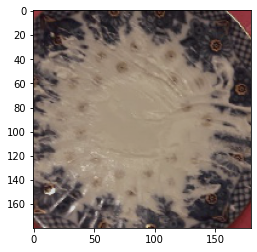

In [6]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [7]:
y_batch

tensor([1, 1, 0, 0, 0, 1, 0, 1])

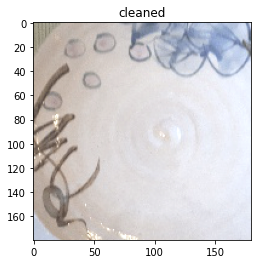

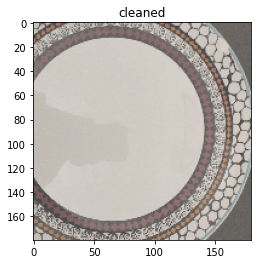

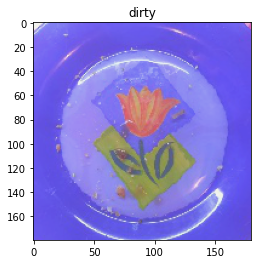

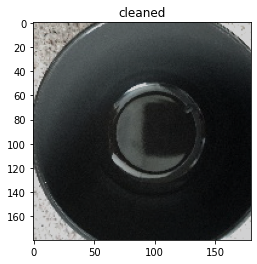

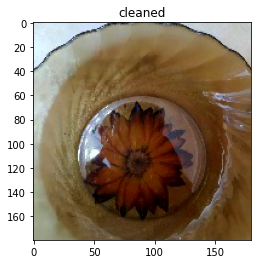

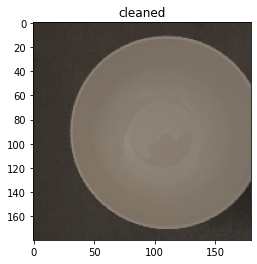

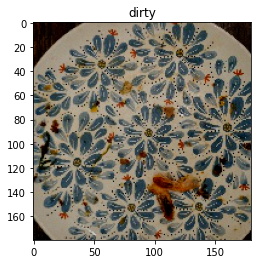

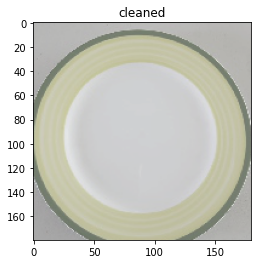

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for X_item, y_item in zip(X_batch, y_batch):
    show_input(X_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs=10):
    loss_train_history = []
    acc_train_history = []
    loss_val_history = []
    acc_val_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_acc += (preds_class == labels.data).float().mean()
                running_loss += loss_value.item()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                loss_train_history.append(epoch_loss)
                acc_train_history.append(epoch_acc)
            else:
                loss_val_history.append(epoch_loss)
                acc_val_history.append(epoch_acc)
            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, loss_train_history, acc_train_history, loss_val_history, acc_val_history

In [10]:
#model = models.resnet34(pretrained=True)
#model = models.resnet18(pretrained=True)
#model = models.resnet50(pretrained=True)
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1);

In [12]:
#4 epochs chosen as after that model starts overfitting
model, loss_train, acc_train, loss_val, acc_val = train_model(model, loss, optimizer, scheduler, num_epochs=4);

Epoch 0/3:
Epoch 1/3:
Epoch 2/3:
Epoch 3/3:


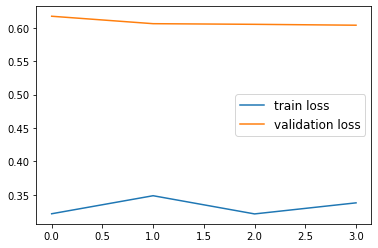

In [13]:
plt.plot(loss_train, label='train loss')
plt.plot(loss_val, label='validation loss')
plt.legend(loc='best', fontsize=12);
plt.show()

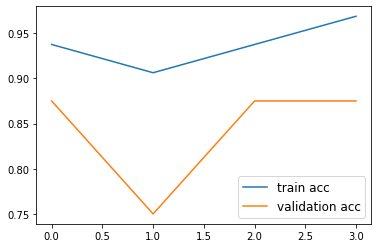

In [14]:
plt.plot(acc_train, label='train acc')
plt.plot(acc_val, label='validation acc')
plt.legend(loc='best', fontsize=12)
plt.show()

In [16]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [17]:
test_dir = 'test'
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
# 0 - cleaned, 1 - dirty
model.eval()
test_predictions = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds = F.softmax(preds, dim=1)[:, 1].data.cpu().numpy()
        test_predictions.extend(preds)

100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


In [19]:
# 0 -cleaned, 1 - dirty
test_preds = list(map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned', test_predictions))
submission = pd.DataFrame({'Id': range(0, len(test_dataset)), 'Label': test_preds})

In [20]:
submission.head()

,Id,Label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [21]:
submission.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
